In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import healpy as hp
sys.path.append('../code/')
from Theory_camb import theory,cosmo

# Useful readings

In [ ]:
# Weak lensing review
https://arxiv.org/pdf/1411.0115.pdf
    
# Likelihood-free-inference (or simulation-based-inference) framework
https://arxiv.org/pdf/2310.17557.pdf

# Make some C_ell predictions

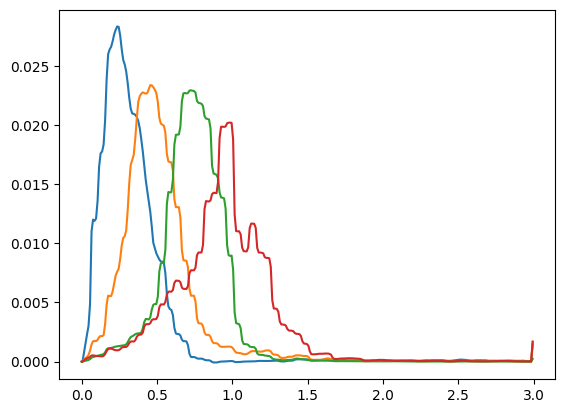

In [3]:
# load redshift distributions (from DES Y3) and plot them.
# DES Y3 weak lensing catalog is divided into 4 redshift bins
desy3_nz = np.loadtxt('../data/des_y3_nz.txt')
for i in range(4):
    mask_bin = desy3_nz[:,0] == i
    plt.plot(desy3_nz[mask_bin,1],desy3_nz[mask_bin,2])
    

In [4]:
import timeit

st = timeit.default_timer()
# choose some cosmological parameters
h = 0.673
s8 = 0.84
om = 0.26
ob = 0.0493
ns = 0.9649
mv = 0.02

# initialise theory code
Cosmo = cosmo(H0=h*100., ombh2=ob*h**2, omch2=(om-ob)*h**2,As = 2e-9,ns=ns,mnu=mv,num_massive_neutrinos=3, w=-1 )
Theory = theory( cosmo= Cosmo,halofit_version='takahashi', sigma_8 = s8, fast = True, max_zs = 2.5, lmax = 2000)


n_bins = 4
# stack n(z)s in a format that our theory code will like (z,nz1,nz2,nz3,nz4)
nzs = []
nzs.append(desy3_nz[desy3_nz[:,0]==0,1])
for i in range(n_bins):
    mask_bin = desy3_nz[:,0] == i
    # normalise and append
    nzs.append(desy3_nz[mask_bin,2]/np.trapz(desy3_nz[mask_bin,2],desy3_nz[mask_bin,1]))
nzs = np.array(nzs).T



# initialise the lensing kernel for our redshift distributions
Theory.get_Wshear(nzs)

# compute cls ---------------------------
Theory.limber(xtype = 'gg',nonlinear=True) 

end = timeit.default_timer()

print (end-st)

Using fast settings. Results my not be accurate
Om_b h^2             =  0.022329
Om_c h^2             =  0.095432
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.739471
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.260475
100 theta (CosmoMC)  =  1.010428
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=     39.46 (m_nu=  0.007 eV)
Age of universe/GYr  =  14.560
zstar                =  1087.74
r_s(zstar)/Mpc       =  151.35
100*theta            =  1.010641
DA(zstar)/Gpc        =  14.97552
zdrag                =  1058.00
r_s(zdrag)/Mpc       =  154.19
k_D(zstar) Mpc       =  0.1336
100*theta_D          =  0.157045
z_EQ (if v_nu=1)     =  2814.52
k_EQ Mpc (if v_nu=1) =  0.008590
100*theta_EQ         =  0.910776
100*theta_rs_EQ      =  0.499069
tau_recomb/Mpc       =  294.29  tau_now/Mpc =  15269.8
Om_b h^2             =  0.022329
Om_c h^2             =  0.095432
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.739471
Om_K              

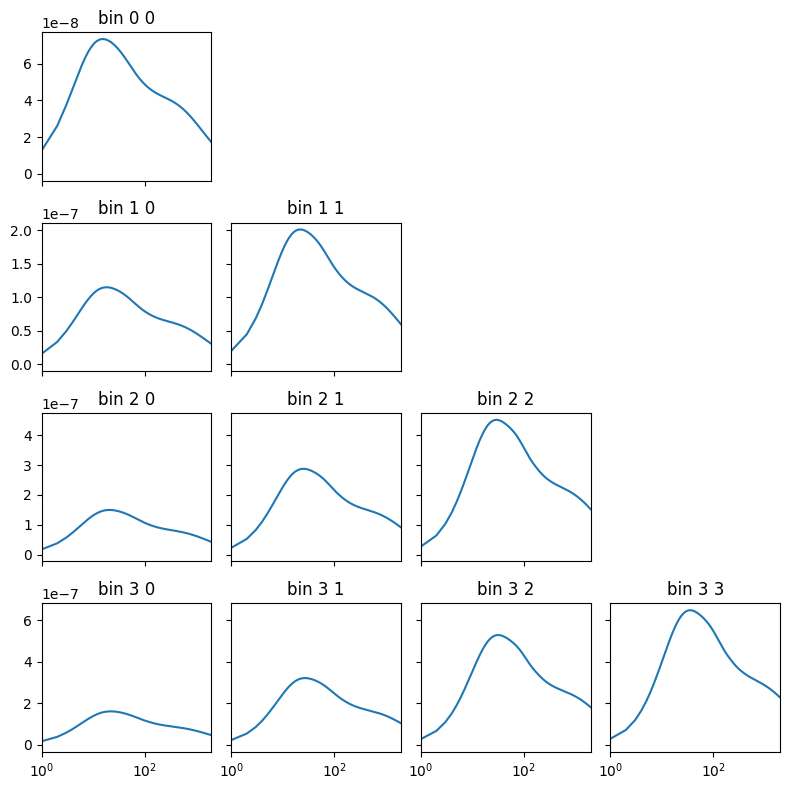

In [5]:

# Initialize the figure and axes
fig, axs = plt.subplots(4, 4, figsize=(8, 8),sharex=True,sharey='row')

# Loop through all subplots to modify them
for i in range(n_bins):
    for j in range(n_bins):
        # Only plot cells where i >= j
        if i >= j:
            # Plot a simple bar or image; here, we're using text for simplicity
            axs[i, j].plot(Theory.clgg[i,j]*np.arange(2001))
            axs[i, j].set_title('bin {0} {1}'.format(i,j))
           # axs[i, j].set_xticks([])  # Remove x-axis ticks
           # axs[i, j].set_yticks([])  # Remove y-axis ticks
        else:
            # Clear the axis if i < j
            axs[i, j].axis('off')
        axs[i,j].set_xscale('log')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.xlim([1,2000])

plt.show()

In [6]:
import glob
output_predictions = '/global/cfs/cdirs/des/mgatti/Dirac/output_folder_cl_predictions_Dirac_sept23_2_noz25/'
f = glob.glob(output_predictions+'/*')

f[0]

'/global/cfs/cdirs/des/mgatti/Dirac/output_folder_cl_predictions_Dirac_sept23_2_noz25/shear_maps_runsP_run021_nside512_noiserel30_rel0'

In [7]:
# let's select the cls only at a few multipole values, and make a datavector
l_ref = (10**np.linspace(np.log10(10),np.log10(1990),20)).astype(int)

t1 = []
ll = []
t2 = []
cl_DV = []
for i in range(n_bins):
    for j in range(n_bins):
        # Only plot cells where i >= j
        if i >= j:
            cl_DV.extend(Theory.clgg[i,j][l_ref])
            t1.extend([i]*len(l_ref))
            t2.extend([j]*len(l_ref))
            ll.extend(l_ref)
            

# healpy cov matrix tests ~

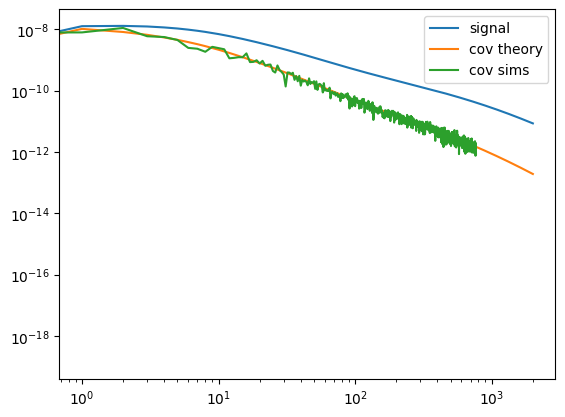

In [8]:
# no shape noise
nside = 256

cls_ = [hp.anafast(hp.synfast(Theory.clgg[0,0],nside = nside,pixwin=False)) for i in range(10)]
cov_s = np.cov((np.array(cls_)).T)

plt.plot(Theory.clgg[0,0],label = 'signal')
plt.plot(np.sqrt(2*Theory.clgg[0,0]**2/(2*np.arange(len(Theory.clgg[0,0]))+1)),label = 'cov theory')
plt.plot(np.sqrt(cov_s.diagonal()),label = 'cov sims')
plt.xscale('log')
plt.yscale('log')
plt.legend()

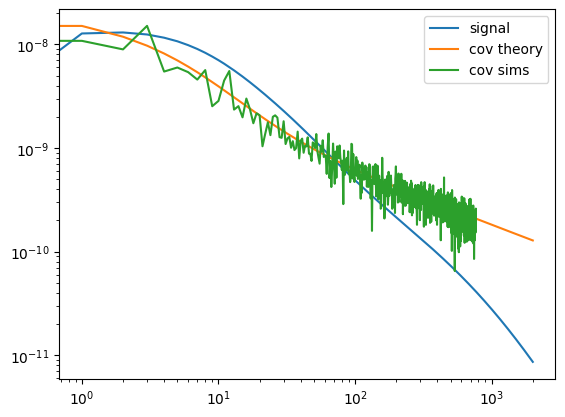

In [9]:
# with shape noise ~
arcmin2_to_sterad = 8.461e-8
sigma_eff = 0.26
area_pix = hp.nside2pixarea(nside, degrees = True)*3600 # in arcmin
n_eff_per_bin = 1. # gal/arcmin
c = sigma_eff**2/(n_eff_per_bin* area_pix) 

c_theo = sigma_eff**2/(n_eff_per_bin/arcmin2_to_sterad) 

cls_ = [hp.anafast(np.random.normal(0,np.sqrt(c),12*nside**2) +hp.synfast(Theory.clgg[0,0],nside = nside,pixwin=False)) for i in range(10)]
cov_s = np.cov((np.array(cls_)).T)

plt.plot(Theory.clgg[0,0],label = 'signal')
plt.plot(np.sqrt(2*(Theory.clgg[0,0]+c_theo*np.ones(len(Theory.clgg[0,0])))**2/(2*np.arange(len(Theory.clgg[0,0]))+1)),label = 'cov theory')
plt.plot(np.sqrt(cov_s.diagonal()),label = 'cov sims')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# covariance matrix

In [10]:
#eq 17 https://arxiv.org/pdf/2012.08568.pdf
def kd(i, j):
    return 1 if i == j else 0

# desy3 numbers
sigma_eff = 0.26
n_eff_per_bin = 1.
f_sky = 1 #0.12
c = sigma_eff**2/(n_eff_per_bin /arcmin2_to_sterad)

cov = np.zeros((len(cl_DV),len(cl_DV)))
for index1 in range(len(cl_DV)):
    for index2 in range(len(cl_DV)):
        if index1 == index2:
            i = t1[index1]
            j = t2[index1]
            k = t1[index2]
            l = t2[index2]
            l_ = ll[index2]
            cov[index1,index2] = (1./(f_sky*(2.*l_+1)))* ((Theory.clgg[i,j][l_] + kd(i,j)*c)*(Theory.clgg[j,l][l_] + kd(j,l)*c)+(Theory.clgg[i,l][l_] + kd(i,l)*c)*(Theory.clgg[j,k][l_] + kd(j,k)*c))
            
            

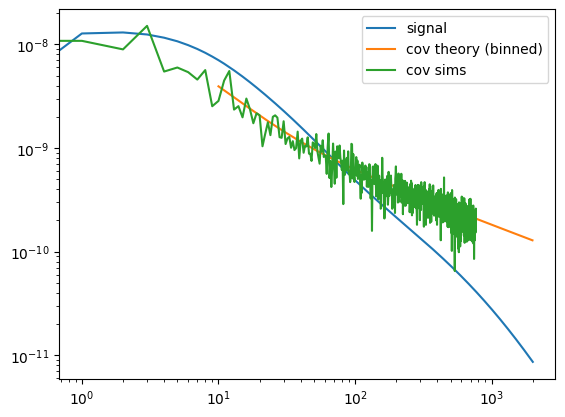

In [11]:
plt.plot(Theory.clgg[0,0],label = 'signal')
#plt.plot(np.sqrt(2*Theory.clgg[0,0]**2/(2*np.arange(len(Theory.clgg[0,0]))+1)),label = 'cov theory')
plt.plot(l_ref,np.sqrt(cov.diagonal())[:20],label = 'cov theory (binned)')
plt.plot(np.sqrt(cov_s.diagonal()),label = 'cov sims')
plt.xscale('log')
plt.yscale('log')
plt.legend()


# noisy DV

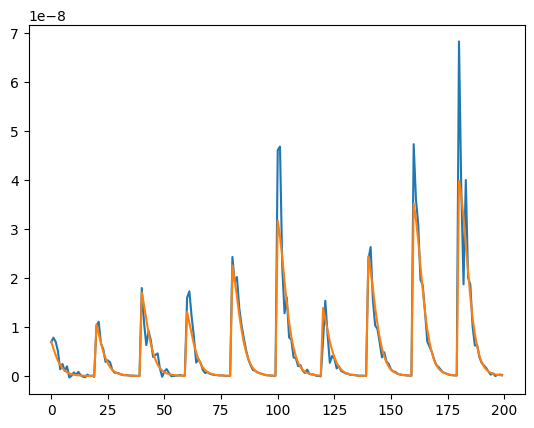

In [12]:
noisy_DV = cl_DV + np.random.normal(0,np.sqrt(cov.diagonal()))
plt.plot(noisy_DV)
plt.plot(cl_DV)